In [46]:
from custom_loss_functions import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter
from joblib import Parallel, delayed
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')


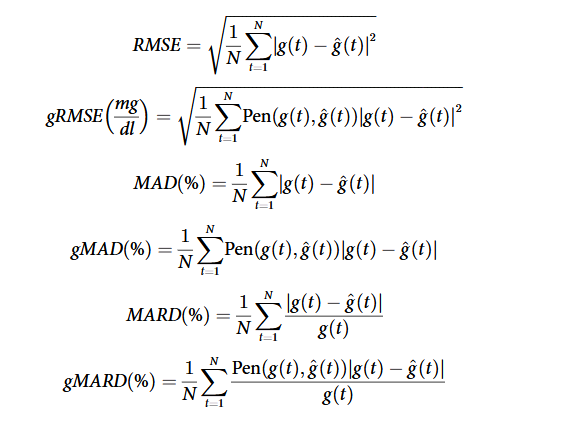

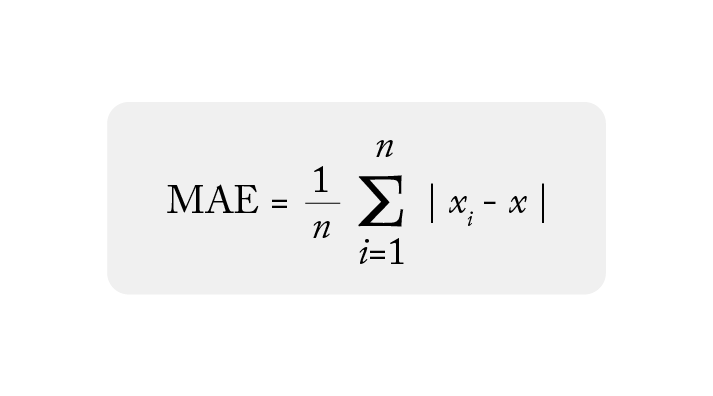

In [47]:
print(loss_function_name_list)

['RMSE', 'cSigP01', 'cSigP06', 'CP', 'gMSE', 'gMAD', 'cSigP01MSE', 'cSigP06MSE']


In [48]:

loss_function_name="cSigP01" # default loss function

loss_function=loss_functions_dic[loss_function_name]
print("INFO: loss_function = ", loss_function)
print("INFO: loss_function_name = ", loss_function_name)

INFO: loss_function =  <function c_sig_p01 at 0x000001F767195CA0>
INFO: loss_function_name =  cSigP01


In [49]:
def evaluar_metrica(funcion, n_jobs=-1):
    # Definir rango de valores para g (verdadero) y ĝ (estimado)
    g_true = np.linspace(0, 500, 500)
    g_est = np.linspace(0, 500, 500)
    G_true, G_est = np.meshgrid(g_true, g_est)

    # Aplicar la función a cada par (g_true, g_est)
    try:
        valores = funcion(G_true, G_est)
        print("Valores vectorizados")
    except:
        pairs = np.column_stack((G_true.ravel(), G_est.ravel()))
        
        # Función auxiliar para procesar cada par
        def process_pair(pair):
            return funcion(pair[0], pair[1])
        
        # Ejecutar en paralelo
        resultados = Parallel(n_jobs=n_jobs)(
            delayed(process_pair)(pair) for pair in pairs
        )
        
        # Reformar el resultado a la forma original
        valores = np.array(resultados).reshape(G_true.shape)
    
    return valores, G_true, G_est

valores, G_true, G_est = evaluar_metrica(loss_function)


Valores vectorizados


In [50]:
print(clinical_penalty(120,120)) #==1?
print(clinical_penalty(85,120)) #==1?
print(clinical_penalty(70,120)) #==1.75?
print(clinical_penalty(55,120)) #==2.5 si g_true <55 ?
print(clinical_penalty(50,120)) #==2.5 si g_true <55 ?
print(clinical_penalty(48,48))
print(clinical_penalty(0,0)) 

tf.Tensor(1.0000036806418595, shape=(), dtype=float64)
tf.Tensor(1.016480413694987, shape=(), dtype=float64)
tf.Tensor(1.7499999999985902, shape=(), dtype=float64)
tf.Tensor(2.48351958605411, shape=(), dtype=float64)
tf.Tensor(2.496291065265048, shape=(), dtype=float64)
tf.Tensor(1.0710421690062564, shape=(), dtype=float64)
tf.Tensor(1.0711388097348942, shape=(), dtype=float64)


In [51]:
print("INFO: loss_function = ", loss_function)
print('zona A:', loss_function(25,25))
print('zona A:', loss_function(35,35))
print('zona A:', loss_function(70,70))
print('zona A:', loss_function(100,100))
print('zona A:', loss_function(150,150))
print('zona A:', loss_function(200,200))
print('zona A:', loss_function(300,300))
print('zona A:', loss_function(400,400))
print('zona A:', loss_function(500,500))
print('zonas por encima de la diagonal (1):')
print('zona B1:', loss_function(100,150))
print('zona C1:', loss_function(150,450))
print('zona D1:', loss_function(35,135))
print('zona E1:', loss_function(35,250))
print('zonas por debajo de la diagonal (2):')
print('zona B2:', loss_function(100,25))
print('zona C2:', loss_function(160,25))
print('zona D2:', loss_function(300,125))
print('zona E2:', loss_function(300,25))
print('zona E2:', loss_function(250,40))

INFO: loss_function =  <function c_sig_p01 at 0x000001F767195CA0>
zona A: tf.Tensor(1.016501324057527, shape=(), dtype=float64)
zona A: tf.Tensor(1.0383354663804083, shape=(), dtype=float64)
zona A: tf.Tensor(1.2967410541857975, shape=(), dtype=float64)
zona A: tf.Tensor(1.2379031273197125, shape=(), dtype=float64)
zona A: tf.Tensor(1.0951194190360665, shape=(), dtype=float64)
zona A: tf.Tensor(1.0402790582957937, shape=(), dtype=float64)
zona A: tf.Tensor(1.0049742055979638, shape=(), dtype=float64)
zona A: tf.Tensor(1.0006874022406702, shape=(), dtype=float64)
zona A: tf.Tensor(1.0001074971592785, shape=(), dtype=float64)
zonas por encima de la diagonal (1):
zona B1: tf.Tensor(2.043564619642259, shape=(), dtype=float64)
zona C1: tf.Tensor(3.0006706946543815, shape=(), dtype=float64)
zona D1: tf.Tensor(3.9396470217460133, shape=(), dtype=float64)
zona E1: tf.Tensor(4.940436929185981, shape=(), dtype=float64)
zonas por debajo de la diagonal (2):
zona B2: tf.Tensor(1.9505788043813945, s

In [52]:
colors = [(0.0, (0.0, 0.8, 0.0)),      # Verde oscuro para valores bajos
        (0.2, (0.5, 1.0, 0.0)),      # Verde claro
        (0.4, (1.0, 1.0, 0.0)),      # Amarillo
        (0.6, (1.0, 0.8, 0.0)),      # Amarillo-naranja
        (0.8, (1.0, 0.4, 0.0)),      # Naranja
        (1.0, (1.0, 0.0, 0.0))]      # Rojo para valores altos


def pintar_metrica(function, loss_function_name="Metric", titulo_x="Reference Concentration (mg/dl)", titulo_y="Prediction Concentration (mg/dl)"):
    
    valores, G_true, G_est = evaluar_metrica(function) 
    
    # Definir colores para el mapa de colores
    colors1 = [(0.0, (0.5, 1.0, 0.5)),      # Verde para 1.0
            (0.25, (0.8, 1.0, 0.2)),     # Verde-amarillo para 1.25
            (0.5, (1.0, 1.0, 0.0)),      # Amarillo para 1.5
            (0.75, (1.0, 0.5, 0.0)),     # Naranja para 2.0
            (1.0, (1.0, 0.0, 0.0))]      # Rojo para 2.5
    
    colors2 = [(0.0, (0.0, 0.8, 0.0)),      # Verde oscuro para valores bajos
             (0.2, (0.5, 1.0, 0.0)),      # Verde claro
             (0.4, (1.0, 1.0, 0.0)),      # Amarillo
             (0.6, (1.0, 0.8, 0.0)),      # Amarillo-naranja
             (0.8, (1.0, 0.4, 0.0)),      # Naranja
             (1.0, (1.0, 0.0, 0.0))]      # Rojo para valores altos
    
    
    colors = colors1
    
    # ------------------------- Figura 1 -------------------------
    plt.clf()
    # Crear un mapa de colores personalizado
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    
    # Crear la figura
    plt.plot(figsize=(8, 6))
    plt.imshow(valores, extent=[0, 500, 0, 500], origin='lower', cmap=cmap, aspect='auto')
    plt.gca().set_facecolor('white')
    cbar = plt.colorbar()
    #cbar.set_ticks([1.0, 1.5, 2.0, 2.5])
    
    # Agregar una línea diagonal blanca para referencia
    plt.plot([0, 500], [0, 500], 'w-', linewidth=1.5)
    
    # Agregar líneas de referencia para las regiones de glucosa
    plt.axvline(x=70, color='w', linestyle='-', linewidth=0.8, alpha=0.8)
    plt.axvline(x=180, color='w', linestyle='-', linewidth=0.8, alpha=0.8)
    
    # Configurar los ejes y etiquetas
    plt.xlabel(titulo_x)
    plt.ylabel(titulo_y)
    plt.title(loss_function_name)
    
    # Mostrar la figura
    plt.tight_layout()
    plt.show()
    
    # ------------------------- Figura 2 -------------------------
    plt.clf()
    cmap = LinearSegmentedColormap.from_list('custom_cmap_3d', colors)
    fig, ax1 = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8, 6))
    surf = ax1.plot_surface(G_true, G_est, valores, cmap=cmap, edgecolor='none', alpha=0.8)
    
    # Agregar barra de color
    plt.contourf(G_true, G_est, valores, zdir='z', offset=0, cmap=cmap, alpha=0.5)
    cbar = plt.colorbar()
    if loss_function_name=="cSigP06" or loss_function_name=="cSigP01":
        cbar.set_ticks(np.arange(1, 5.1, 0.5))
    
    plt.gca().set_facecolor('white')
    
    ax1.set_xlabel(titulo_x)
    ax1.set_ylabel(titulo_y)
    if loss_function_name=="cSigP06":
        ax1.set_zlabel("cSigp06")
    elif loss_function_name=="cSigP01":
        ax1.set_zlabel("cSigp01")
    plt.xticks(np.arange(0, 551, 50))
    plt.yticks(np.arange(0, 551, 50))
    ax1.set_xlim(0, 500)
    ax1.set_ylim(0, 500)  # Ajustado para que coincida con la imagen
    #ax.set_zlim(0, 4)
    ax1.view_init(elev=30, azim=-100)  # Ajustar ángulo de visualización
    
    # Configurar formato científico para el eje Z
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax1.zaxis.set_major_formatter(formatter)
    
    plt.tight_layout()
    plt.show()
    
    # ------------------------- Figura 3 -------------------------
    plt.clf()
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    plt.plot(figsize=(8, 6))
    plt.imshow(valores, extent=[0, 500, 0, 500], origin='lower', 
                    cmap=cmap, aspect='auto')
    
    # Agregar barra de color
    cbar = plt.colorbar()
    if loss_function_name=="cSigP06" or loss_function_name=="cSigP01":
        cbar.set_ticks(np.arange(1, 5.1, 0.5))
    plt.gca().set_facecolor('white')
    
    # Líneas de nivel gSE
    #levels = [0.5, 1.0, 1.5, 2.0, 2.5]
    #contour = ax2.contour(G_true, G_est, valores, levels, colors='black', linewidths=1.5)
    
    # Set up plot
    #plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    print(loss_function_name + " + Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks(np.arange(0, 551, 50))
    plt.yticks(np.arange(0, 551, 50))
    
    # Set axes lengths
    plt.gca().set_xlim([0, 500])
    plt.gca().set_ylim([0, 500])
    plt.gca().set_aspect((500) / (500))
    
    linewidth = 1
    # Plot zone lines
    plt.plot([0, 500], [0, 500], ':', c='black', linewidth=linewidth)  #Theoretical 45 regression line
    plt.plot([0, 175 / 3], [70, 70], '-', c='black', linewidth=linewidth)
    # plt.plot([175/3, 320], [70, 500], '-', c='black', linewidth=linewidth)
    plt.plot([175 / 3, 500 / 1.2], [70, 500], '-', c='black', linewidth=linewidth)  # Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 500], '-', c='black', linewidth=linewidth)
    plt.plot([0, 70], [180, 180], '-', c='black', linewidth=linewidth)
    plt.plot([70, 390], [180, 500], '-', c='black', linewidth=linewidth) ###################
    # plt.plot([70, 70], [0, 175/3], '-', c='black', linewidth=linewidth)
    plt.plot([70, 70], [0, 56], '-', c='black', linewidth=linewidth)  # Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 500],[175/3, 320],'-', c='black', linewidth=linewidth)
    
    plt.plot([70, 500], [56, 400], '-', c='black', linewidth=linewidth)
    plt.plot([180, 180], [0, 70], '-', c='black', linewidth=linewidth)
    plt.plot([180, 500], [70, 70], '-', c='black', linewidth=linewidth)
    plt.plot([240, 240], [70, 180], '-', c='black', linewidth=linewidth)
    plt.plot([240, 500], [180, 180], '-', c='black', linewidth=linewidth)
    plt.plot([130, 180], [0, 70], '-', c='black', linewidth=linewidth)
    
    fontsize = 12
    # Add zone titles
    plt.text(380, 420, "A", fontsize=fontsize)
    plt.text(420, 380, "A", fontsize=fontsize)
    plt.text(170, 100, "B2", fontsize=fontsize)
    plt.text(100, 170, "B1", fontsize=fontsize)
    plt.text(150, 400, "C1", fontsize=fontsize)
    plt.text(150, 10, "C2", fontsize=fontsize)
    plt.text(30, 120, "D1", fontsize=fontsize)
    plt.text(370, 120, "D2", fontsize=fontsize)
    plt.text(30, 340, "E1", fontsize=fontsize)
    plt.text(370, 15, "E2", fontsize=fontsize)
    
    
    plt.tight_layout()
    plt.show()
    

In [53]:
p=0.6
def csig_partida(y_true, y_pred, p=p):
    """Función de penalización clínica para glucosa en sangre.
    Basada en el Clark Error Grid (CEG).
    """
    output = tf.cast(y_pred, 'float64') #EJE Y
    target = tf.cast(y_true, 'float64') #EJE X
    
    #p=0.1 #Yo lo elijo, siempre que p>0.0
    #p= 0.1, 0.6
    # de 1 a 5 lineal el maximo o de 1 a 25 cuadratico
    
    
    ##ZONA A ################################
    A=tf.cast(1.0, 'float64')
    
    #Criterio: D1 = D superior a diagonal
    ##ZONA D1 ################################
    #D11 (recta horizontal entre A y D1)
    pD11=p #Yo lo elijo, siempre que p>0.0
    #mD11=0.0 #0.0 por definición
    cD11=70.0 #70.0 por definición
    D11=sigmoid(output, cD11, pD11) #D11=sigmoide(output - mD11*target, pD11, cD11)
    #D12 (mini diagonal entre A y D1)
    pD12=p #Yo lo elijo, siempre que p>0.0
    mD12=1.2 #(500-70)/(500/1.2-175/3)=6/5=1.2 (+20% error between output and target)
    cD12=0.0 #70.0-mD12*175.0/3.0=0.0 
    D12=sigmoid(output - mD12 * target, cD12, pD12)
    #D13 (recta vertical entre D1 y B1 o C1)
    pD13=-p #Yo lo elijo, siempre que p<0.0
    #mD13=1.0 
    cD13=70.0 #70.0 por definición
    D13=sigmoid(target, cD13, pD13)
    
    D1=D11*D12*D13*2.0
    
    ##ZONA E1 #############################
    #E11 (recta entre D1 y E1)
    # Esta zona no es necesaria definirla
    # se crea sola al sumar D1 y C1, que pasan por debajo de E1
    pE11=p #Yo lo elijo, siempre que p>0.0
    cE11=180.0 #180.0 por definición
    E11=sigmoid(output, cE11, pE11)
    #E12 (recta entre E1 y C1)
    #pE12=-p #Yo lo elijo, siempre que p<0.0
    #cE12=70.0 #70.0 por definición
    #E12=sigmoide(target, cE12, pE12)
    
    E1=tf.cast(0.0, 'float64')
    #E1=E11*E12
    
    ##ZONA C1 #############################
    #C11 (recta entre C1 y D1)
    C11=E11
    #C12 (diagonal entre C1 y B1)
    pC12=p #Yo lo elijo, siempre que p>0.0
    #mC12=1.0 #(500-180)/(390-70)=1.0
    cC12=110.0 #180-mC12*70
    C12=sigmoid(output - target, cC12, pC12)
    
    C1=C11*C12

    ##ZONA B1 #############################
    #B11 (horizontal entre A y B1)
    B11=D11 
    #B12 (diagonal entre A y B1)
    B12=D12 #(+20% error between output and target)
    
    B1=B11*B12
    
    ##ZONA B2 #############################
    #B21 (recta entre A y B2)
    pB21=p #Yo lo elijo, siempre que p>0.0
    #mB21=1.0 #1.0 por definición
    cB21=70.0 #70.0 por definición
    B21=sigmoid(target, cB21, pB21)
    #B22 (diagonal entre A y B2)
    pB22=-p #Yo lo elijo, siempre que p<0.0
    mB22=0.8 #(400-56)/(500-70)=4/5=0.8 (-20% error between output and target)
    cB22=0.0  #56-mB22*70=0.0
    B22=sigmoid(output - mB22 * target, cB22, pB22)
    
    B2=B21*B22
    
    ##ZONA C2 #############################
    #C21 (diagonal entre B2 y C2)
    pC21=-p #Yo lo elijo, siempre que p<0.0
    mC21=1.4 #70/(180-130)=7/5=1.4
    cC21=-182.0 #(0-70)/(180-130)*130.0
    C21=sigmoid(output - mC21 * target, cC21, pC21)
    #C22 (recta entre E2 y D2)
    pC22=-p #Yo lo elijo, siempre que p<0.0
    cC22=70.0 #70.0 por definición
    C22=sigmoid(output, cC22, pC22)
    
    C2=C21*C22
    
    ##ZONA D2 #############################
    #D21 (recta vertical entre B2 y D2)
    pD21=p #Yo lo elijo, siempre que p<0.0
    cD21=240.0 #240.0 por definición
    D21=sigmoid(target, cD21, pD21)
    #D22 (recta horizontal entre B2 y D2)
    pD22=-p #Yo lo elijo, siempre que p<0.0
    cD22=180.0 #180.0 por definición
    D22=sigmoid(output, cD22, pD22)
    
    D2=D21*D22*2.0
    
    ##ZONA E2 #############################
    #E21 (recta vertical entre C2 y E2)
    pE21=p #Yo lo elijo, siempre que p>0.0
    cE21=180.0 #180.0 por definición
    E21=sigmoid(target, cE21, pE21)
    #E22 (recta horizontal entre B2 o D2 y E2)
    E22=C22
    
    #E2=E21*E22*(1.0+2.0*sigmoide(target, cD21, -pD21))
    E2=2.0 * E21 * E22 * sigmoid(target, cD21, -pD21)
    #E2=2.0*(E21-D21)*E22 
    
    return [B1,B2,C1,C2,D1,D2,E2]

valores, G_true, G_est = evaluar_metrica(csig_partida)
partes=['B1','B2','C1','C2','D1','D2','E2']

print(csig_partida((240+180)/2,0,p=0.1)[6]) #==2?
print(csig_partida(240,0,p=0.1)[6]) #==1?
print(csig_partida(195,35,p=0.1)[6]) #==2?

Valores vectorizados
tf.Tensor(1.813141563090663, shape=(), dtype=float64)
tf.Tensor(0.9966185783352449, shape=(), dtype=float64)
tf.Tensor(1.5697804039092442, shape=(), dtype=float64)


In [60]:
colors = [(0.0, (0.0, 0.8, 0.0)),      # Verde oscuro para valores bajos
        (0.2, (0.5, 1.0, 0.0)),      # Verde claro
        (0.4, (1.0, 1.0, 0.0)),      # Amarillo
        (0.6, (1.0, 0.8, 0.0)),      # Amarillo-naranja
        (0.8, (1.0, 0.4, 0.0)),      # Naranja
        (1.0, (1.0, 0.0, 0.0))]      # Rojo para valores altos


def pintar_metrica(valores, G_true, G_est, loss_function_name="Metric", titulo_x="Reference Concentration (mg/dl)", titulo_y="Prediction Concentration (mg/dl)"):
    
    #valores, G_true, G_est = evaluar_metrica(function) 
    
    # Definir colores para el mapa de colores
    colors1 = [(0.0, (0.5, 1.0, 0.5)),      # Verde para 1.0
            (0.25, (0.8, 1.0, 0.2)),     # Verde-amarillo para 1.25
            (0.5, (1.0, 1.0, 0.0)),      # Amarillo para 1.5
            (0.75, (1.0, 0.5, 0.0)),     # Naranja para 2.0
            (1.0, (1.0, 0.0, 0.0))]      # Rojo para 2.5
    
    colors2 = [(0.0, (0.0, 0.8, 0.0)),      # Verde oscuro para valores bajos
             (0.2, (0.5, 1.0, 0.0)),      # Verde claro
             (0.4, (1.0, 1.0, 0.0)),      # Amarillo
             (0.6, (1.0, 0.8, 0.0)),      # Amarillo-naranja
             (0.8, (1.0, 0.4, 0.0)),      # Naranja
             (1.0, (1.0, 0.0, 0.0))]      # Rojo para valores altos
    
    
    colors = colors1
    
    # ------------------------- Figura 1 -------------------------
    plt.clf()
    # Crear un mapa de colores personalizado
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    
    # Crear la figura
    plt.plot(figsize=(8, 6))
    plt.imshow(valores, extent=[0, 500, 0, 500], origin='lower', cmap=cmap, aspect='auto')
    plt.gca().set_facecolor('white')
    cbar = plt.colorbar()
    #cbar.set_ticks([1.0, 1.5, 2.0, 2.5])
    
    # Agregar una línea diagonal blanca para referencia
    plt.plot([0, 500], [0, 500], 'w-', linewidth=1.5)
    
    # Agregar líneas de referencia para las regiones de glucosa
    plt.axvline(x=70, color='w', linestyle='-', linewidth=0.8, alpha=0.8)
    plt.axvline(x=180, color='w', linestyle='-', linewidth=0.8, alpha=0.8)
    
    # Configurar los ejes y etiquetas
    plt.xlabel(titulo_x)
    plt.ylabel(titulo_y)
    plt.title(loss_function_name)
    
    # Mostrar la figura
    plt.tight_layout()
    #plt.show()
    
    # ------------------------- Figura 2 -------------------------
    plt.clf()
    cmap = LinearSegmentedColormap.from_list('custom_cmap_3d', colors)
    fig, ax1 = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8, 6))
    surf = ax1.plot_surface(G_true, G_est, valores, cmap=cmap, edgecolor='none', alpha=0.8)
    
    # Agregar barra de color
    plt.contourf(G_true, G_est, valores, zdir='z', offset=0, cmap=cmap, alpha=0.5)
    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(0, 1, 11))
    if loss_function_name in ["D1","D2","E2"]:
        cbar.set_ticks(np.linspace(0, 2, 21))
        print("hola")
    
    if loss_function_name=="cSigP06" or loss_function_name=="cSigP01":
        cbar.set_ticks(np.arange(1, 5.1, 0.5))
    #cbar.set_ticks(np.arange(0,1.000000001,0.1))

    
    plt.gca().set_facecolor('white')
    
    ax1.set_xlabel(titulo_x)
    ax1.set_ylabel(titulo_y)
    if loss_function_name=="cSigP06":
        ax1.set_zlabel("cSigp06")
    elif loss_function_name=="cSigP01":
        ax1.set_zlabel("cSigp01")
    plt.xticks(np.arange(0, 551, 50))
    plt.yticks(np.arange(0, 551, 50))
    ax1.set_xlim(0, 500)
    ax1.set_ylim(0, 500)  # Ajustado para que coincida con la imagen
    #ax.set_zlim(0, 4)
    ax1.view_init(elev=30, azim=-100)  # Ajustar ángulo de visualización
    #ax1.dist = 10
    # Configurar formato científico para el eje Z
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax1.zaxis.set_major_formatter(formatter)
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(loss_function_name + f' - cSigp06_3D.png', dpi=600, bbox_inches='tight')
    
    # ------------------------- Figura 3 -------------------------
    plt.clf()
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    #plt.plot(figsize=(8, 6))
    plt.imshow(valores, extent=[0, 500, 0, 500], origin='lower', 
                    cmap=cmap, aspect='auto')
    
    # Agregar barra de color
    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(0, 1, 11))
    if loss_function_name in ["D1","D2","E2"]:
        cbar.set_ticks(np.linspace(0, 2, 21))
        
    if loss_function_name=="cSigP06" or loss_function_name=="cSigP01":
        cbar.set_ticks(np.arange(1, 5.1, 0.5))
    plt.gca().set_facecolor('white')
    
    # Líneas de nivel gSE
    #levels = [0.5, 1.0, 1.5, 2.0, 2.5]
    #contour = ax2.contour(G_true, G_est, valores, levels, colors='black', linewidths=1.5)
    
    # Set up plot
    #plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    print(loss_function_name + " + Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks(np.arange(0, 551, 50))
    plt.yticks(np.arange(0, 551, 50))
    
    # Set axes lengths
    plt.gca().set_xlim([0, 500])
    plt.gca().set_ylim([0, 500])
    plt.gca().set_aspect((500) / (500))
    
    linewidth = 1
    # Plot zone lines
    plt.plot([0, 500], [0, 500], ':', c='black', linewidth=linewidth)  #Theoretical 45 regression line
    plt.plot([0, 175 / 3], [70, 70], '-', c='black', linewidth=linewidth)
    # plt.plot([175/3, 320], [70, 500], '-', c='black', linewidth=linewidth)
    plt.plot([175 / 3, 500 / 1.2], [70, 500], '-', c='black', linewidth=linewidth)  # Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 500], '-', c='black', linewidth=linewidth)
    plt.plot([0, 70], [180, 180], '-', c='black', linewidth=linewidth)
    plt.plot([70, 390], [180, 500], '-', c='black', linewidth=linewidth) ###################
    # plt.plot([70, 70], [0, 175/3], '-', c='black', linewidth=linewidth)
    plt.plot([70, 70], [0, 56], '-', c='black', linewidth=linewidth)  # Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 500],[175/3, 320],'-', c='black', linewidth=linewidth)
    
    plt.plot([70, 500], [56, 400], '-', c='black', linewidth=linewidth)
    plt.plot([180, 180], [0, 70], '-', c='black', linewidth=linewidth)
    plt.plot([180, 500], [70, 70], '-', c='black', linewidth=linewidth)
    plt.plot([240, 240], [70, 180], '-', c='black', linewidth=linewidth)
    plt.plot([240, 500], [180, 180], '-', c='black', linewidth=linewidth)
    plt.plot([130, 180], [0, 70], '-', c='black', linewidth=linewidth)
    
    fontsize = 12
    # Add zone titles
    plt.text(380, 420, "A", fontsize=fontsize)
    plt.text(420, 380, "A", fontsize=fontsize)
    plt.text(170, 100, "B2", fontsize=fontsize)
    plt.text(100, 170, "B1", fontsize=fontsize)
    plt.text(150, 400, "C1", fontsize=fontsize)
    plt.text(150, 10, "C2", fontsize=fontsize)
    plt.text(30, 120, "D1", fontsize=fontsize)
    plt.text(370, 120, "D2", fontsize=fontsize)
    plt.text(30, 340, "E1", fontsize=fontsize)
    plt.text(370, 15, "E2", fontsize=fontsize)
    
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(loss_function_name + f' - cSigp06_2D.png', dpi=600, bbox_inches='tight')
    

B1 + Clarke Error Grid


<Figure size 640x480 with 0 Axes>

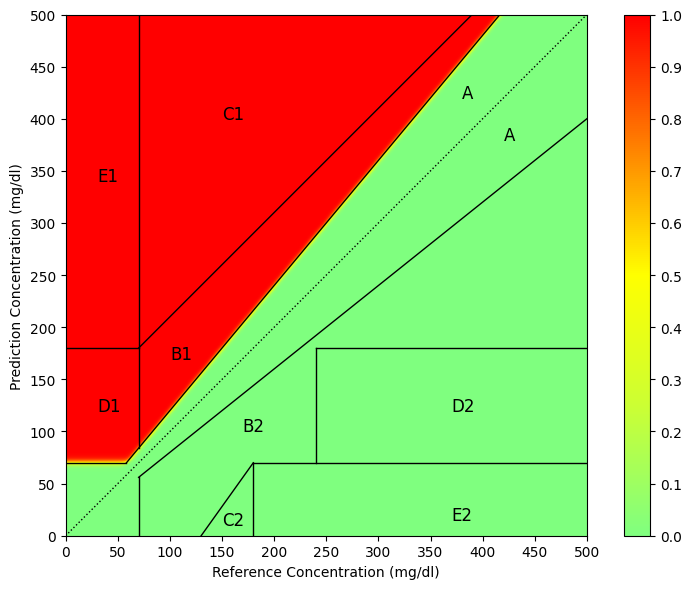

B2 + Clarke Error Grid


<Figure size 640x480 with 0 Axes>

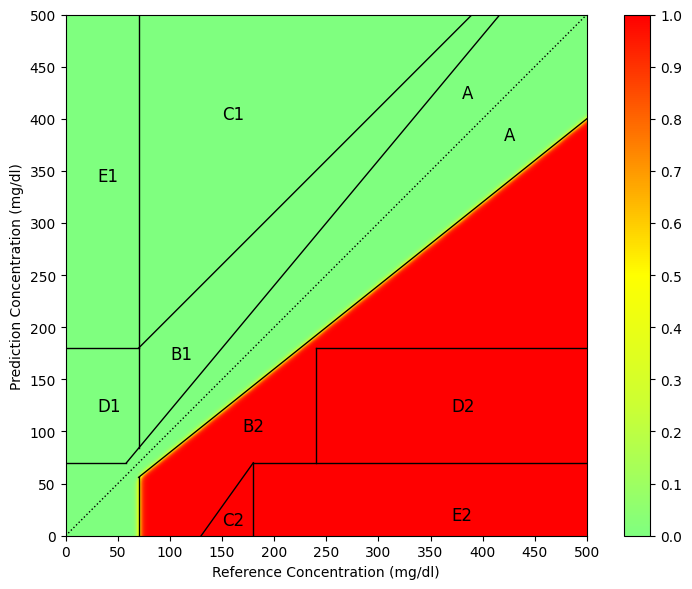

C1 + Clarke Error Grid


<Figure size 640x480 with 0 Axes>

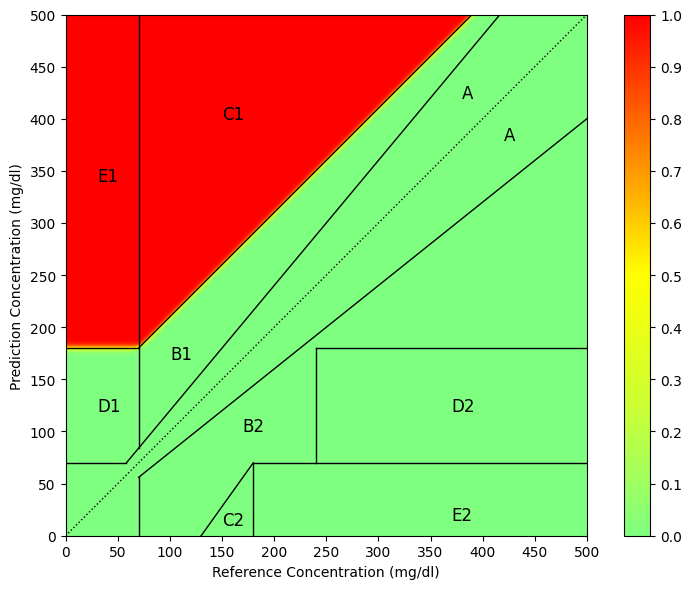

C2 + Clarke Error Grid


<Figure size 640x480 with 0 Axes>

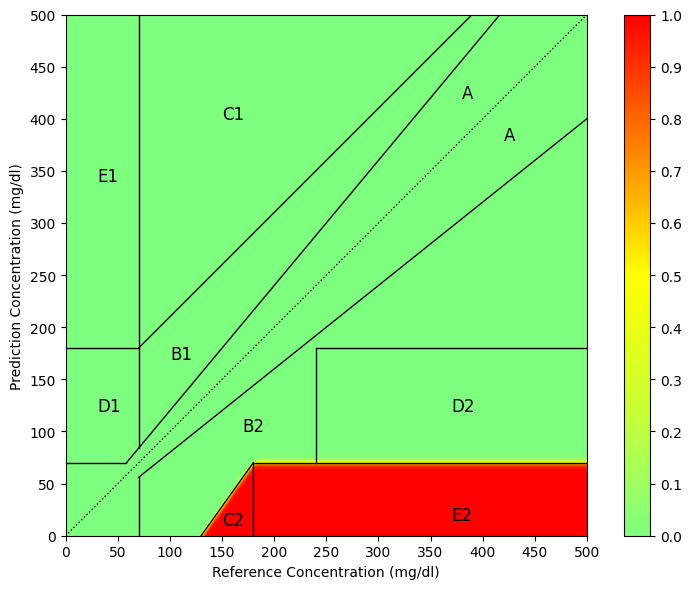

hola
D1 + Clarke Error Grid


<Figure size 640x480 with 0 Axes>

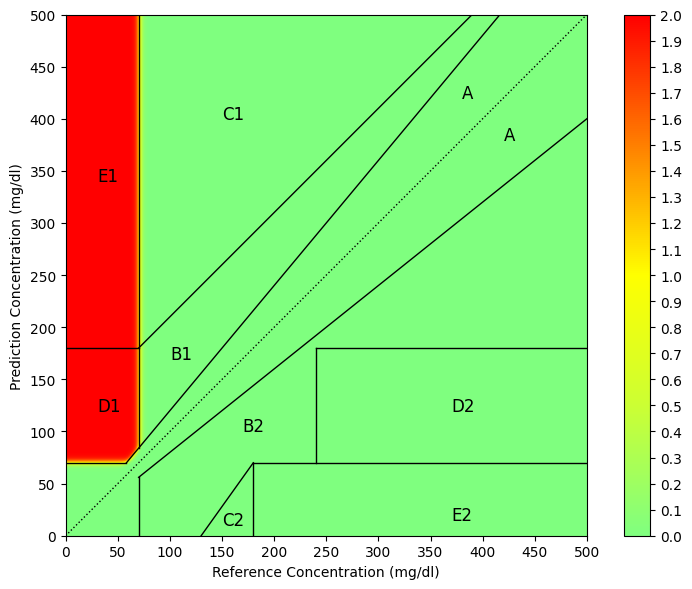

hola
D2 + Clarke Error Grid


<Figure size 640x480 with 0 Axes>

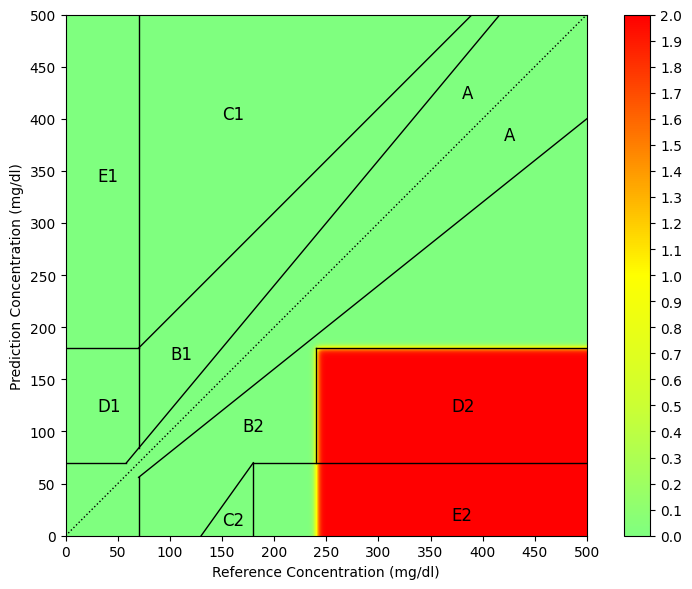

hola
E2 + Clarke Error Grid


<Figure size 640x480 with 0 Axes>

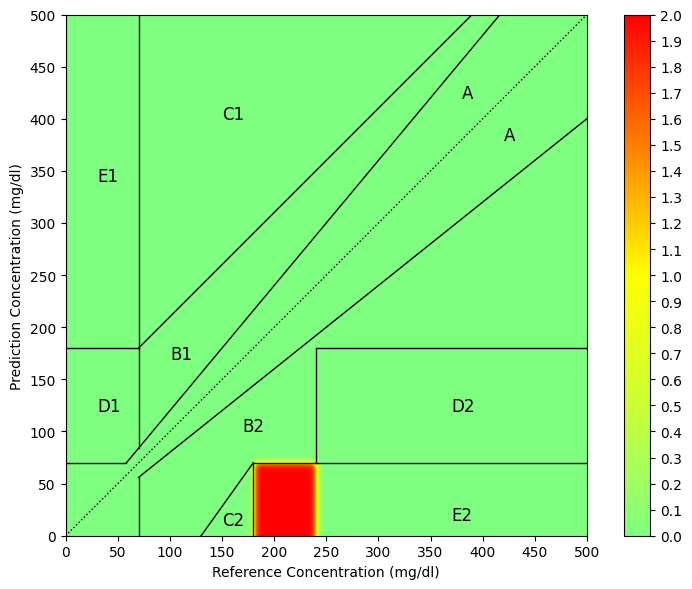

In [61]:
for v, p in zip(valores, partes):
    #print(v,G_true, G_est)
    pintar_metrica(v, G_true, G_est, loss_function_name=p)
    plt.show()

hola
E2 + Clarke Error Grid


<Figure size 640x480 with 0 Axes>

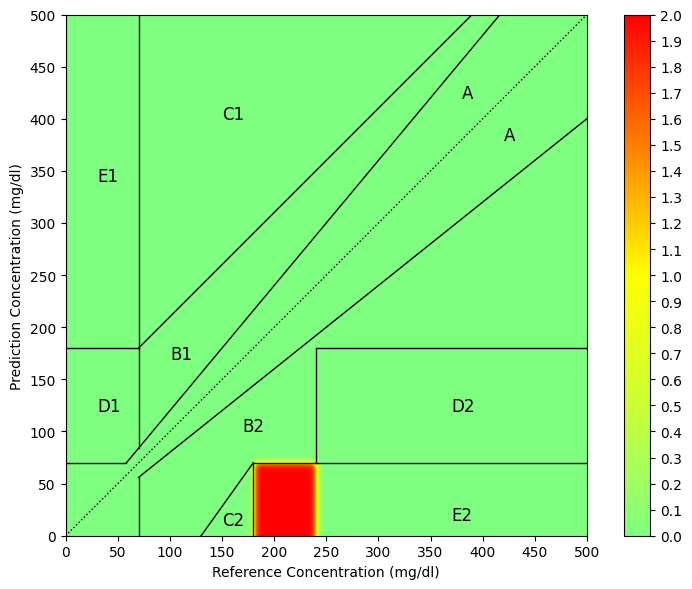

In [62]:
pintar_metrica(valores[6], G_true, G_est, loss_function_name="E2")